In [52]:
boro_q = b_epnt + '$select=distinct boroname'.replace(' ', '%20')

In [53]:
boro_q

'https://data.cityofnewyork.us/resource/uvpi-gqnh.json?$select=distinct%20boroname'

In [81]:
import dash_table

In [412]:
%%writefile dash_app.py
import os
import pandas as pd
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
import plotly.graph_objects as go
# import plotly.figure_factory as ff
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate
from plotly.tools import mpl_to_plotly
import seaborn as sns
sns.set()

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# base data loading
b_epnt = 'https://data.cityofnewyork.us/resource/uvpi-gqnh.json?'
tree_q = b_epnt + '$select=distinct spc_common'.replace(' ', '%20')
boro_q = b_epnt + '$select=distinct boroname'.replace(' ', '%20')
df = pd.read_json(tree_q.replace(' ', '%20'))
tree_names = pd.read_json(tree_q.replace(' ', '%20')).values.flatten()
tree_names = tree_names[~pd.isna(tree_names)].tolist()
boro_names = pd.read_json(boro_q.replace(' ', '%20')).values.flatten()
boro_names = boro_names[~pd.isna(boro_names)].tolist()


app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

server = app.server

app.layout = html.Div([
    html.H3('Select a species and borough to search'),
    
    ## selection divs + button
    # spc_common
    html.Div([
        dcc.Dropdown(
            id='spc_common',         
            options=[{'label':i, 'value': i} for i in tree_names],
            # multi=True,
            value=tree_names[0],
            style={'width': '220px'}),
        html.Div(id='spc_common_sel')
    ], style={'float':'left'}),
    
    # boro
    html.Div([
        dcc.Dropdown(
            id='boro',         
            options=[{'label':i, 'value': i} for i in boro_names],
            # multi=True,
            value=boro_names[0],
            style={'width': '220px'}),
        html.Div(id='boro_sel')
    ], style={'float':'right'}),
    
    # search button
    html.Button('Search', id='search_button', style={'display':'inline-block'}),
    
    # query_bar
    dcc.Graph(id='query_bar',),
    
    # stwd_bar
    dcc.Graph(id='stwd_bar',),
    
    # query_table
    html.Div(id='query_table', style={'padding': 20},), 
    
    
    
])

##### CALLBACKS #####
@app.callback(
    Output('spc_common_sel', 'children'),
    [Input('spc_common', 'value')]
)
def update_spc_common_sel(name):
    return f'Tree species selected: {name}'

@app.callback(
    Output('boro_sel', 'children'),
    [Input('boro', 'value')]
)
def update_boro_sel(name):
    return f'Borough selected: {name}'

@app.callback(
    [Output('query_table', 'children'), 
     Output('query_bar', 'figure'),
     Output('stwd_bar', 'figure')], 
    [Input('search_button', 'n_clicks')],
    [State('spc_common', 'value'),
     State('boro', 'value')]
)
def do_query(clicks, tree, boro, limit=999999):
    if not clicks:
        raise PreventUpdate
        
    # do query + get data
    q = b_epnt + f"$select=spc_common,health,steward,count(tree_id)" +\
            f"&$where=boroname=\'{boro}\'" +\
            f" AND spc_common=\'{tree}\'" +\
            f"&$group=spc_common,health, steward"
    df = pd.read_json(q.replace(' ', '%20'))

    # make overall health condition 
    hdf = df.groupby('health').sum()
    hdf['health_proportion'] = hdf['count_tree_id']/hdf['count_tree_id'].sum()
    hdf.reset_index(inplace=True)
    hdf['health'] = pd.Categorical(hdf['health'], ['Poor', 'Fair', 'Good'])
    hdf.sort_values('health', axis=0, inplace=True)
    query_bar = go.Figure()
    query_bar.add_trace(go.Bar(x = hdf['health'], y=hdf['health_proportion'],
                               text='count: ' + hdf['count_tree_id'].astype(str),
                               textposition='auto', marker = dict(color=['Red','Blue', 'Green'])))
    query_bar.update_layout(title_text = 'Health Proportions')

    # make steward bar
    df['health'] = pd.Categorical(df['health'], ['Poor', 'Fair', 'Good'])
    df.sort_values(['steward', 'health'], inplace=True)
    df['color'] = df['health'].map({'Poor': 'Red', 'Fair': 'Blue', 'Good': 'Green'})
    prop = []
    stwd_grouped = df.groupby('steward')
    for stwd, group in stwd_grouped:     
        prop.extend(group['count_tree_id']/group['count_tree_id'].sum())
    df['health_proportion'] = prop
    df['steward'] = pd.Categorical(df['steward'], ['None', '1or2', '3or4', '4orMore'])
    df.sort_values(['steward', 'health'], axis=0, inplace=True)
    stwd_bar = go.Figure()
    stwd_bar.add_trace(go.Bar(x = [df['steward'], df['health']],
                         y=df['health_proportion'],
                         text='count: ' + df['count_tree_id'].astype(str),
                         textposition='auto', marker = dict(color=df['color'])))
    stwd_bar.update_layout(title_text = 'Health Proportions by Steward')


    
    # make the table
    columns = [{'name': i, 'id': i,} for i in (df.columns)]
    query_tb = dash_table.DataTable(
        data = df.to_dict('rows'), 
        columns = columns,
        fixed_columns={'headers': True, 'data': 1},
        fixed_rows={'headers': True,'data': 0},
        style_table={
            'maxHeight': '250px', 'maxWidth': '900px',
            'overflowY': 'scroll', 'overflowX': 'scroll'},
        style_cell={'width': '150px'},
        style_data_conditional=[{
            'if': {
                'row_index': 'odd'
            },
            'backgroundColor': 'rgb(248, 248, 248)'
        }],
        style_header={
            'backgroundColor': 'rgb(230, 230, 230)',
            'fontWeight': 'bold',
            'border': '1px solid blue',
        },
    )
    return query_tb, query_bar, stwd_bar


if __name__ == '__main__':
    app.run_server(debug=True)

Overwriting dash_app.py


In [410]:
df['health'].map({'Poor': 'Red', 'Fair': 'Blue', 'Good': 'Green'})

0      Red
3     Blue
7    Green
6      Red
5     Blue
1    Green
8      Red
4     Blue
2    Green
9    Green
Name: health, dtype: category
Categories (3, object): [Red, Blue, Green]

In [209]:
#     df = df.fillna('Null')
#     prop = []
#     for spc, group in df.groupby('spc_common'):
#         prop.extend(group['count_tree_id']/group['count_tree_id'].sum())
#     df['health_proportion'] = prop
#         # how to make sure I got ALL the data?
#         result = df.shape

In [ ]:
, mpl_to_plotly(catplot.fig)

In [390]:
pd.Categorical(['None', '1or2', '3or4', '4orMore'], categories = ['None', '1or2', '3or4', '4orMore'], ordered=True)

[None, 1or2, 3or4, 4orMore]
Categories (4, object): [None < 1or2 < 3or4 < 4orMore]

In [359]:
df

,spc_common,health,steward,count_tree_id,health_proportion
0,silver maple,Poor,None,37,0.033575
3,silver maple,Fair,None,218,0.197822
7,silver maple,Good,None,847,0.768603
6,silver maple,Poor,1or2,8,0.034188
5,silver maple,Fair,1or2,32,0.136752
1,silver maple,Good,1or2,194,0.829060
8,silver maple,Poor,3or4,1,0.030303
4,silver maple,Fair,3or4,4,0.121212
2,silver maple,Good,3or4,28,0.848485
9,silver maple,Good,4orMore,6,1.000000


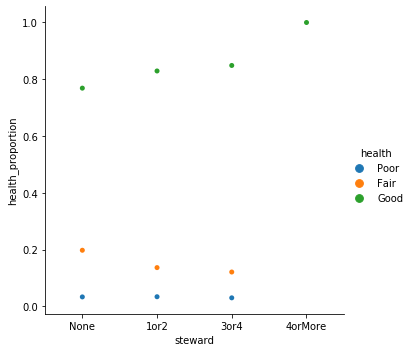

In [379]:
f_grid = sns.catplot(x='steward', y='health_proportion', hue='health', jitter=False, data=df)

In [380]:
catplot_fig = f_grid.fig

In [395]:
type(f_grid.fig)

matplotlib.figure.Figure

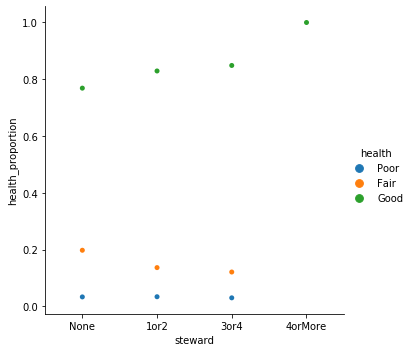

In [393]:
catplot_fig.set

In [ ]:
#     # make sns catplot
#     catplot = sns.catplot(x='steward', y='health_proportion', hue='health', data=df)
#     catplot.set(xticks=pd.Categorical(['None', '1or2', '3or4', '4orMore'], categories = ['None', '1or2', '3or4', '4orMore'], ordered=True))
    # catplot
#     dcc.Graph(id='catplot'),
    # # find out what n_clicks is
# @app.callback(
#     Output('test_n_clicks', 'children'),
#     [Input('search_button', 'n_clicks')],
# )
# def test(clicks):
#     print(clicks)
#     return clicks


In [371]:
from plotly.tools import mpl_to_plotly

In [372]:
mpl_to_plotly??

In [312]:
# tree = 'pagoda dogwood'
tree = 'silver maple'
boro = 'Brooklyn'

In [349]:
# do query + get data
q = b_epnt + f"$select=spc_common,health,steward,count(tree_id)" +\
        f"&$where=boroname=\'{boro}\'" +\
        f" AND spc_common=\'{tree}\'" +\
        f"&$group=spc_common,health, steward"
df = pd.read_json(q.replace(' ', '%20'))

# make overall health condition 
hdf = df.groupby('health').sum()
hdf['health_proportion'] = hdf['count_tree_id']/hdf['count_tree_id'].sum()
hdf.reset_index(inplace=True)
hdf['health'] = pd.Categorical(hdf['health'], ['Good', 'Fair', 'Poor'])
hdf.sort_values('health', axis=0, inplace=True)
query_bar = px.bar(hdf, x='health', y='health_proportion', color='health', barmode='group')

# make steward bar
df['health'] = pd.Categorical(df['health'], ['Poor', 'Fair', 'Good'])
df.sort_values(['steward', 'health'], inplace=True)
prop = []
stwd_grouped = df.groupby('steward')
for stwd, group in stwd_grouped:     
    prop.extend(group['count_tree_id']/group['count_tree_id'].sum())
df['health_proportion'] = prop
df['steward'] = pd.Categorical(df['steward'], ['None', '1or2', '3or4', '4orMore'])
df.sort_values(['steward', 'health'], axis=0, inplace=True)
stwd_bar = go.Figure()
stwd_bar.add_trace(go.Bar(x = [df['steward'], df['health']],
                     y=df['health_proportion'],
                     text='count: ' + df['count_tree_id'].astype(str),
                     textposition='inside',))

In [342]:
df

,spc_common,health,steward,count_tree_id
0,silver maple,Poor,None,37
1,silver maple,Good,1or2,194
2,silver maple,Good,3or4,28
3,silver maple,Fair,None,218
4,silver maple,Fair,3or4,4
5,silver maple,Fair,1or2,32
6,silver maple,Poor,1or2,8
7,silver maple,Good,None,847
8,silver maple,Poor,3or4,1
9,silver maple,Good,4orMore,6


In [ ]:
stwd_grouped

In [333]:
stwd_grouped.groups

{'None': Int64Index([0, 3, 7], dtype='int64'),
 '1or2': Int64Index([6, 5, 1], dtype='int64'),
 '3or4': Int64Index([8, 4, 2], dtype='int64')}

In [324]:
stwd_grouped.groups

{'Null': Int64Index([], dtype='int64'),
 'None': Int64Index([0, 3, 7], dtype='int64'),
 '1or2': Int64Index([6, 5, 1], dtype='int64'),
 '3or4': Int64Index([8, 4, 2], dtype='int64')}

In [325]:
len(prop)

9

In [327]:
df['steward'].value_counts()

3or4    3
1or2    3
None    3
Null    0
Name: steward, dtype: int64

In [328]:
df

,spc_common,health,steward,count_tree_id
0,silver maple,Poor,None,37
3,silver maple,Fair,None,218
7,silver maple,Good,None,847
6,silver maple,Poor,1or2,8
5,silver maple,Fair,1or2,32
1,silver maple,Good,1or2,194
8,silver maple,Poor,3or4,1
4,silver maple,Fair,3or4,4
2,silver maple,Good,3or4,28
9,silver maple,Good,NaN,6


In [295]:

# do query + get data
q = b_epnt + f"$select=spc_common,health,steward,count(tree_id)" +\
        f"&$where=boroname=\'{boro}\'" +\
        f" AND spc_common=\'{tree}\'" +\
        f"&$group=spc_common,health, steward"
df = pd.read_json(q.replace(' ', '%20'))

# make overall health condition 
hdf = df.groupby('health').sum()
hdf['health_proportion'] = hdf['count_tree_id']/hdf['count_tree_id'].sum()
hdf.reset_index(inplace=True)
hdf['health'] = pd.Categorical(hdf['health'], ['Good', 'Fair', 'Poor'])
hdf.sort_values('health', axis=0, inplace=True)
query_bar = px.bar(hdf, x='health', y='health_proportion', color='health', barmode='group')

# make steward bar
df['steward'] = pd.Categorical(df['steward'], ['None', '1or2', '3or4'])
df['health'] = pd.Categorical(df['health'], ['Poor', 'Fair', 'Good'])
df.sort_values(['steward', 'health'], inplace=True)
prop = []
stwd_grouped = df.groupby('steward')
for stwd, group in stwd_grouped:     
    prop.extend(group['count_tree_id']/group['count_tree_id'].sum())
df['health_proportion'] = prop
stwd_bar = go.Figure()
stwd_bar.add_trace(go.Bar(x = [df['steward'], df['health']],
                     y=df['health_proportion'],
                     text='count: ' + df['count_tree_id'].astype(str),
                     textposition='inside',))

,spc_common,health,steward,count_tree_id,health_proportion
7,pagoda dogwood,Poor,None,3,0.063830
1,pagoda dogwood,Fair,None,6,0.127660
4,pagoda dogwood,Good,None,38,0.808511
5,pagoda dogwood,Poor,1or2,2,0.068966
0,pagoda dogwood,Fair,1or2,3,0.103448
2,pagoda dogwood,Good,1or2,24,0.827586
6,pagoda dogwood,Poor,3or4,1,0.250000
3,pagoda dogwood,Good,3or4,3,0.750000


In [294]:
fig

In [225]:
query_bar = px.bar(df, x='spc_common', y='health_proportion', color='health', barmode='group', )
query_bar

In [185]:
tree = 'silver maple'
boro = 'Brooklyn'
q = b_epnt + f"$select=steward,spc_common,health,count(tree_id)" +\
        f"&$where=boroname=\'{boro}\'" +\
        f" AND spc_common=\'{tree}\'" +\
        f"&$group=steward,spc_common,health"
df = pd.read_json(q.replace(' ', '%20'))
df = df.fillna('Null')
prop = []
for spc, group in df.groupby('spc_common'):     
    prop.extend(group['count_tree_id']/group['count_tree_id'].sum())
    df['health_proportion'] = prop

In [186]:
df

,steward,spc_common,health,count_tree_id,health_proportion
0,1or2,silver maple,Fair,32,0.023273
1,3or4,silver maple,Good,28,0.020364
2,4orMore,silver maple,Good,6,0.004364
3,3or4,silver maple,Poor,1,0.000727
4,None,silver maple,Fair,218,0.158545
5,None,silver maple,Good,847,0.616000
6,1or2,silver maple,Poor,8,0.005818
7,1or2,silver maple,Good,194,0.141091
8,None,silver maple,Poor,37,0.026909
9,3or4,silver maple,Fair,4,0.002909


In [161]:
import plotly.express as px

In [162]:
px.update_layout??

Object `px.update_layout` not found.


In [123]:
import dash
import dash_core_components as dcc
import dash_table as dt
import dash_html_components as html

from dash.dependencies import Output, Input
from dash.exceptions import PreventUpdate

import plotly.graph_objs as go

sample_data = {
    'series': {
        'data': [
            {'title': 'Game of Thrones', 'score': 9.5},
            {'title': 'Stranger Things', 'score': 8.9},
            {'title': 'Vikings', 'score': 8.6}
        ],
        'style': {
            'backgroundColor': '#ff998a'
        }
    },
    'movies': {
        'data': [
            {'title': 'Rambo', 'score': 7.7},
            {'title': 'The Terminator', 'score': 8.0},
            {'title': 'Alien', 'score': 8.5}
        ],
        'style': {
            'backgroundColor': '#fff289'
        }
    }
}

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1('Multi output example'),
    dcc.Dropdown(id='data-dropdown', options=[
        {'label': 'Movies', 'value': 'movies'},
        {'label': 'Series', 'value': 'series'}
    ], value='movies'),
    html.Div([
        dcc.Graph(id='graph'),
        dt.DataTable(id='data-table', columns=[
            {'name': 'Title', 'id': 'title'},
            {'name': 'Score', 'id': 'score'}
        ])
    ])
], id='container')


@app.callback([
    Output('graph', 'figure'),
    Output('data-table', 'data'),
    Output('data-table', 'columns'),
    Output('container', 'style')
], [Input('data-dropdown', 'value')])
def multi_output(value):
    if value is None:
        raise PreventUpdate

    selected = sample_data[value]
    data = selected['data']
    columns = [
        {'name': k.capitalize(), 'id': k}
        for k in data[0].keys()
    ]
    figure = go.Figure(
        data=[
            go.Bar(x=[x['score']], text=x['title'], name=x['title'])
            for x in data
        ]
    )

    return figure, data, columns, selected['style']

In [124]:
sample_data

{'series': {'data': [{'title': 'Game of Thrones', 'score': 9.5},
   {'title': 'Stranger Things', 'score': 8.9},
   {'title': 'Vikings', 'score': 8.6}],
  'style': {'backgroundColor': '#ff998a'}},
 'movies': {'data': [{'title': 'Rambo', 'score': 7.7},
   {'title': 'The Terminator', 'score': 8.0},
   {'title': 'Alien', 'score': 8.5}],
  'style': {'backgroundColor': '#fff289'}}}

In [125]:
data = sample_data['series']['data']

In [128]:
figure = go.Figure(
        data=[
            go.Bar(x=[x['score']], text=x['title'], name=x['title'])
            for x in data
        ]
)

In [131]:
data

[{'title': 'Game of Thrones', 'score': 9.5},
 {'title': 'Stranger Things', 'score': 8.9},
 {'title': 'Vikings', 'score': 8.6}]

In [132]:
for x in data:
    print(x)

{'title': 'Game of Thrones', 'score': 9.5}
{'title': 'Stranger Things', 'score': 8.9}
{'title': 'Vikings', 'score': 8.6}


In [130]:
figure.show()

# reference

In [ ]:
%%writefile ../../lendingclub/app/app.py
import os
import pandas as pd
from sqlalchemy import create_engine
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
import plotly.graph_objects as go
import plotly.express as px
from dash.dependencies import Input, Output


from lendingclub import config

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']


# load api_loans df and historical scores df
disk_engine = create_engine(f'sqlite:///{config.lc_api_db}')
df = pd.read_sql('lc_api_loans',
                 con=disk_engine,
                 parse_dates=[
                     'accept_d', 'exp_d', 'list_d', 'credit_pull_d',
                     'review_status_d', 'ils_exp_d', 'last_seen_list_d'
                 ])
hist_df = pd.read_feather(
    os.path.join(config.data_dir, 'all_eval_loan_info_scored.fth'))

# setup some constants for use in app
rounds = sorted(df['list_d'].dt.hour.unique())
min_date = df['list_d'].min().date()
max_date = df['list_d'].max().date()
print(min_date, max_date)

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    html.H3('API loans'),
    html.Div([
        dcc.DatePickerRange(id='api-loans-date-picker-range',
                            start_date=max_date,
                            end_date=max_date,
                            min_date_allowed=min_date,
                            # for some reason I couldn't select max date
                            max_date_allowed=max_date + pd.DateOffset(days=1),),
        html.Div(id='api-loans-date-picker-range-info')
    ]),
    html.Div([
        dcc.Dropdown(id='api-loans-round-dropdown',
                 options=[{'label':i, 'value': i} for i in rounds],
                 multi=True,
                 value=rounds),
        html.Div(id='api-loans-round-dropdown-info')
    ]),    
    dcc.Graph(id='api-loans-graph', ),
    dash_table.DataTable(
        id='api-table',
        columns=[{
            "name": i,
            "id": i
        } for i in df.columns],
        fixed_columns={
            'headers': True,
            'data': 1
        },
        fixed_rows={
            'headers': True,
            'data': 0
        },
        style_table={
            'maxHeight': '250px',
            'maxWidth': '900px',
            'overflowY': 'scroll',
            'overflowX': 'scroll'
        },
        style_cell={'width': '150px'},
        style_data_conditional=[{
            'if': {
                'row_index': 'odd'
            },
            'backgroundColor': 'rgb(248, 248, 248)'
        }],
        style_header={
            'backgroundColor': 'rgb(230, 230, 230)',
            'fontWeight': 'bold',
            'border': '1px solid pink',
        },
        style_data={},
    ),
    html.H3('CSV loans'),

])

##### CALLBACKS #####
@app.callback(
    Output('api-table', 'data'), 
    [Input('api-loans-date-picker-range', 'start_date'),
     Input('api-loans-date-picker-range', 'end_date'),
     Input('api-loans-round-dropdown', 'value'),]
)
def update_api_table(start_date, end_date, listing_sess):
    sub_df = df.query('list_d >= @start_date and list_d <= @end_date and list_d_hour in @listing_sess')
    return sub_df.to_dict('records')

@app.callback(
    Output('api-loans-date-picker-range-info', 'children'),
    [Input('api-loans-date-picker-range', 'start_date'),
     Input('api-loans-date-picker-range', 'end_date'),]
)
def update_api_loans_date_picker_range_info(start_date, end_date):
    return f'Dates selected from {start_date} to {end_date}'

@app.callback(
    Output('api-loans-round-dropdown-info', 'children'),
    [Input('api-loans-round-dropdown', 'value'),]
)
def update_api_loans_round_dropdown_info(value):
    '''
    So far, haven't been able to find how to sort multi-select dropdown.
    '''
    return f'Selected daily loan release rounds {", ".join([str(i) for i in sorted(value)])}'

@app.callback(
    Output('api-loans-graph', 'figure'), 
    [Input('api-loans-date-picker-range', 'start_date'),
     Input('api-loans-date-picker-range', 'end_date'),
     Input('api-loans-round-dropdown', 'value'),]
)
def update_api_loans_graph(start_date, end_date, listing_sess):
    sub_df = df.query('list_d >= @start_date and list_d <= @end_date and list_d_hour in @listing_sess')
    fig = px.histogram(sub_df, x='catboost_comb_20', nbins=100, histnorm='probability density', color='sub_grade', marginal='rug')
    return fig


if __name__ == '__main__':
    app.run_server(debug=True)

In [55]:
import dash_core_components as dcc

In [66]:
dcc.

Object `dcc.button` not found.


In [47]:
import numpy as np

In [49]:
import pandas as pd

In [50]:
pd.isna(np.nan)

True

In [ ]:
np.not_equal

# To delete

In [ ]:
#     html.Div([
#         dcc.Dropdown(id='api-loans-round-dropdown',
#                  options=[{'label':i, 'value': i} for i in rounds],
#                  multi=True,
#                  value=rounds),
#         html.Div(id='api-loans-round-dropdown-info')
#     ]),    
#     dcc.Graph(id='api-loans-graph', ),
    
    # table div?

In [ ]:
from lendingclub import config




# load api_loans df and historical scores df
disk_engine = create_engine(f'sqlite:///{config.lc_api_db}')
df = pd.read_sql('lc_api_loans',
                 con=disk_engine,
                 parse_dates=[
                     'accept_d', 'exp_d', 'list_d', 'credit_pull_d',
                     'review_status_d', 'ils_exp_d', 'last_seen_list_d'
                 ])
hist_df = pd.read_feather(
    os.path.join(config.data_dir, 'all_eval_loan_info_scored.fth'))

# setup some constants for use in app
rounds = sorted(df['list_d'].dt.hour.unique())
min_date = df['list_d'].min().date()
max_date = df['list_d'].max().date()
print(min_date, max_date)